In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import chi2_contingency


In [35]:
# --- Setup ---
sns.set_style("whitegrid")
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

# Define color palettes
party_colors = {
    'Republican Party': '#E24A33',
    'Democratic Party': '#348ABD',
    'Other': '#777777'
}

platform_colors = {
    'Twitter': '#1DA1F2',
    'Facebook': '#4267B2',
    'InstagramDirect': '#E1306C',
    'Other': '#777777'
}

sentiment_colors = {
    'Negative': '#E24A33',
    'Neutral': '#348ABD',
    'Positive': '#988ED5'
}

# Load data
df = pd.read_csv('stratifiedSentimentData\socialMedia_with_advanced_sentiment.csv')


C:\Users\cassi\AppData\Local\Temp\ipykernel_29512\1039381515.py:27: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('stratifiedSentimentData\socialMedia_with_advanced_sentiment.csv')


In [25]:

# --- Data Preparation ---
# Clean and standardize columns
df['platform'] = df['attributes.search_data_fields.platform_name'].str.strip()
df['party'] = df['actor_attributes.Registered Political Party'].str.strip()
df['state'] = df['actor_attributes.State'].str.upper().str.strip()

# Group minor categories
major_platforms = ['Twitter', 'Facebook', 'InstagramDirect']
df['platform_group'] = df['platform'].where(df['platform'].isin(major_platforms), 'Other')

major_parties = ['Republican Party', 'Democratic Party']
df['party_group'] = df['party'].where(df['party'].isin(major_parties), 'Other')

swing_states = ['AZ', 'GA', 'MI', 'NC', 'NV', 'PA', 'WI']
df['state_group'] = df['state'].where(df['state'].isin(swing_states), 'Other')

# Map sentiment labels
label_map = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}
df['sentiment'] = df['roberta_label'].map(label_map)


In [26]:
# --- Visualization Functions ---
def plot_sentiment_distribution(data, x_var, title, order=None):
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(
        data=data,
        x=x_var,
        hue='sentiment',
        palette=sentiment_colors,
        order=order,
        hue_order=['Negative', 'Neutral', 'Positive']
    )
    
    # Calculate group totals
    group_totals = data[x_var].value_counts().loc[order]
    
    # Add percentage annotations
    for container in ax.containers:
        for i, rect in enumerate(container):
            # Calculate percentage within group
            group = order[i] if order else data[x_var].unique()[i]
            percentage = 100 * rect.get_height() / group_totals[group]
            
            # Position annotation
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_height() + 0.01 * group_totals.max()
            
            ax.annotate(
                f'{percentage:.0f}%', 
                xy=(x, y),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10
            )

    plt.title(f"{title}\n(Percentages show distribution within each {x_var} group)", pad=20)
    plt.xlabel(x_var.replace('_', ' ').title(), labelpad=10)
    plt.ylabel('Post Count', labelpad=10)
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
    sns.despine()
    plt.tight_layout()
    plt.show()


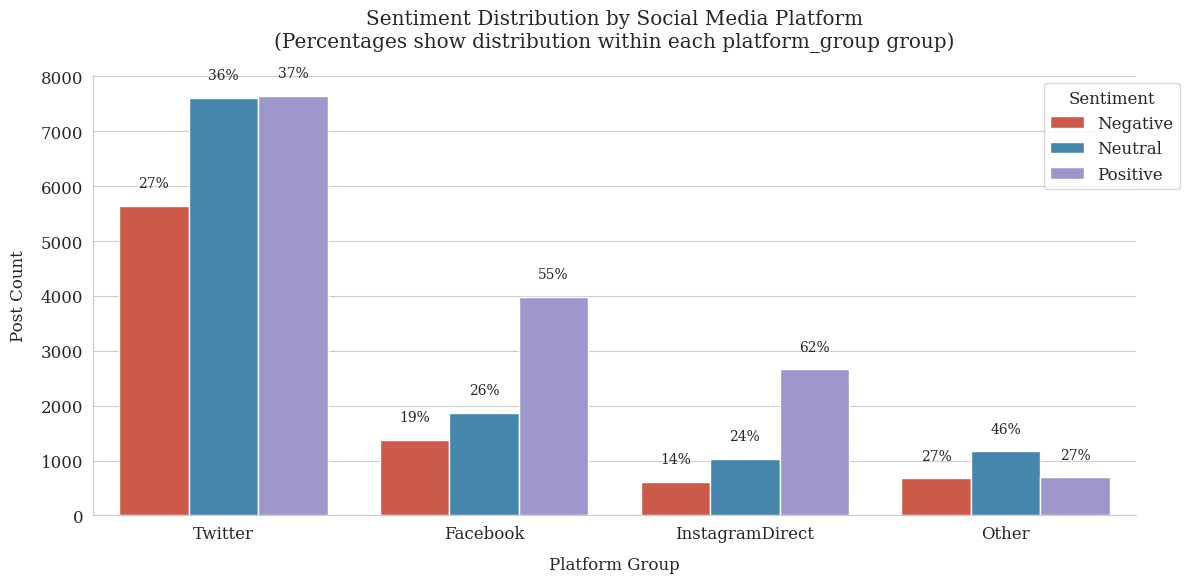

In [27]:

# --- Sentiment by Platform ---
plot_sentiment_distribution(
    df,
    x_var='platform_group',
    title='Sentiment Distribution by Social Media Platform',
    order=major_platforms + ['Other'],
)


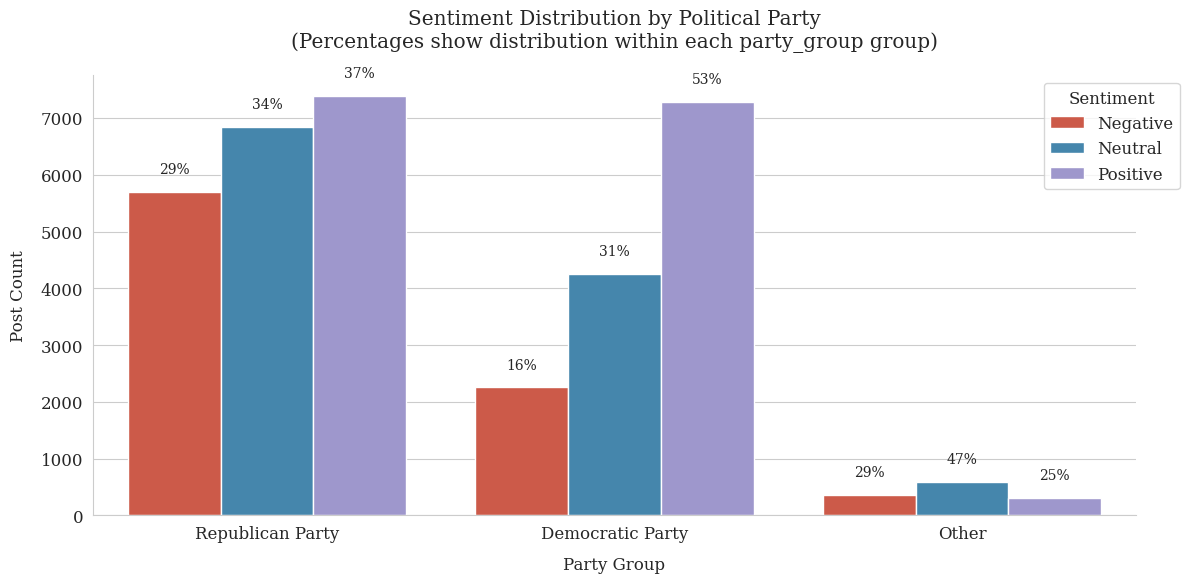

In [28]:

# --- Sentiment by Party ---
plot_sentiment_distribution(
    df,
    x_var='party_group',
    title='Sentiment Distribution by Political Party',
    order=major_parties + ['Other'],
)


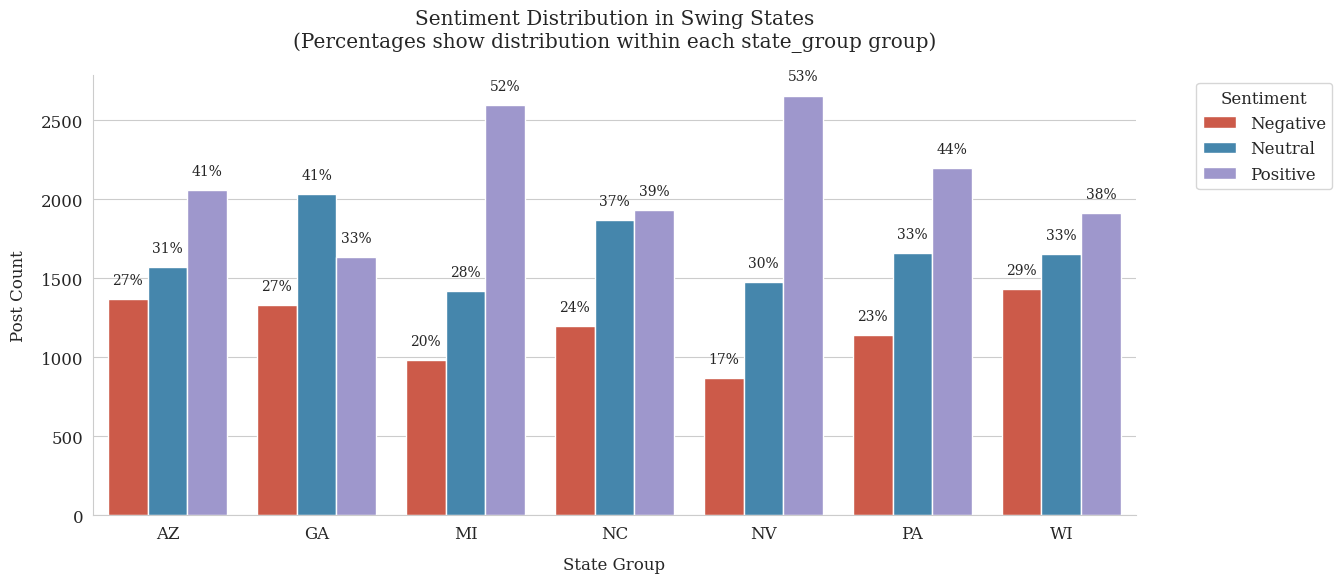

In [29]:

# --- Sentiment by State ---
plot_sentiment_distribution(
    df[df['state_group'] != 'Other'],
    x_var='state_group',
    title='Sentiment Distribution in Swing States',
    order=swing_states,
)


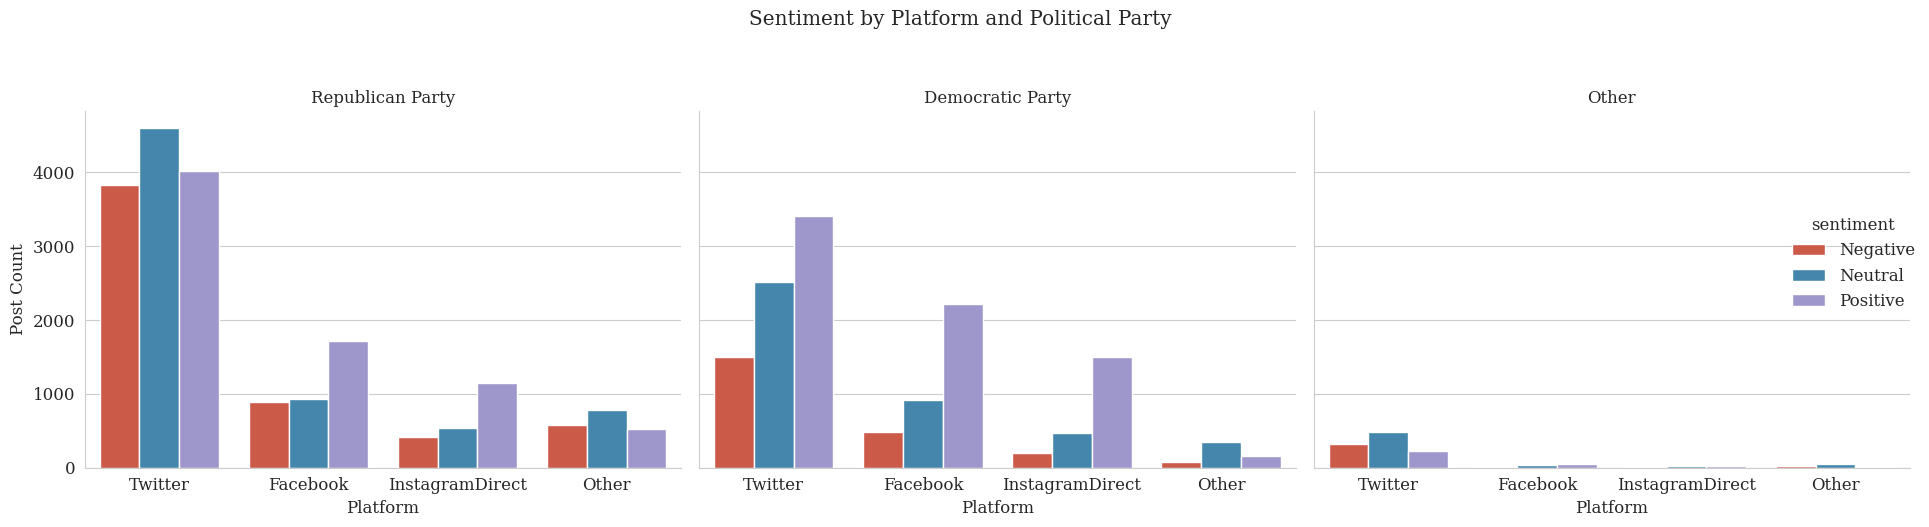

In [30]:

# --- Platform-Party Interaction ---
if all(col in df.columns for col in ['platform_group', 'party_group']):
    g = sns.catplot(
        data=df,
        x='platform_group',
        hue='sentiment',
        col='party_group',
        kind='count',
        palette=sentiment_colors,
        order=major_platforms + ['Other'],
        hue_order=['Negative', 'Neutral', 'Positive'],
        col_order=major_parties + ['Other'],
        height=5,
        aspect=1.2
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Platform", "Post Count")
    g.figure.suptitle('Sentiment by Platform and Political Party', y=1.05)  # Fixed deprecated .fig
    plt.tight_layout()
    plt.savefig('sentiment_platform_party.png', dpi=300, bbox_inches='tight')
    plt.show()


In [31]:

# --- Statistical Analysis ---
def run_chi2_test(data, var1, var2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test for {var1} vs {var2}:")
    print(f"χ² = {chi2:.2f}, p = {p:.4f}")

run_chi2_test(df, 'sentiment', 'platform_group')
run_chi2_test(df, 'sentiment', 'party_group')
run_chi2_test(df[df['state_group'] != 'Other'], 'sentiment', 'state_group')


Chi-square test for sentiment vs platform_group:
χ² = 1686.69, p = 0.0000

Chi-square test for sentiment vs party_group:
χ² = 1204.85, p = 0.0000

Chi-square test for sentiment vs state_group:
χ² = 778.81, p = 0.0000
